Costa Rican Household Poverty Level Prediction

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from tqdm import tqdm
import shap
import featuretools as ft
import warnings
warnings.filterwarnings('ignore')
import time

# 1. Check datasets
## 1.1 Read datasets

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df_train = pd.read_csv('/content/drive/My Drive/data/costa rican/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/data/costa rican/test.csv')

In [11]:
print('df_train shape:', df_train.shape, '  ', 'df_test shape: ', df_test.shape)

df_train shape: (9557, 143)    df_test shape:  (23856, 142)


In [12]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [13]:
df_test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324


## 1.2 Make description df

In [14]:
description = [
("v2a1"," Monthly rent payment"),
("hacdor"," =1 Overcrowding by bedrooms"),
("rooms","  number of all rooms in the house"),
("hacapo"," =1 Overcrowding by rooms"),
("v14a"," =1 has toilet in the household"),
("refrig"," =1 if the household has refrigerator"),
("v18q"," owns a tablet"),
("v18q1"," number of tablets household owns"),
("r4h1"," Males younger than 12 years of age"),
("r4h2"," Males 12 years of age and older"),
("r4h3"," Total males in the household"),
("r4m1"," Females younger than 12 years of age"),
("r4m2"," Females 12 years of age and older"),
("r4m3"," Total females in the household"),
("r4t1"," persons younger than 12 years of age"),
("r4t2"," persons 12 years of age and older"),
("r4t3"," Total persons in the household"),
("tamhog"," size of the household"),
("tamviv"," number of persons living in the household"),
("escolari"," years of schooling"),
("rez_esc"," Years behind in school"),
("hhsize"," household size"),
("paredblolad"," =1 if predominant material on the outside wall is block or brick"),
("paredzocalo"," =1 if predominant material on the outside wall is socket (wood, zinc or absbesto"),
("paredpreb"," =1 if predominant material on the outside wall is prefabricated or cement"),
("pareddes"," =1 if predominant material on the outside wall is waste material"),
("paredmad"," =1 if predominant material on the outside wall is wood"),
("paredzinc"," =1 if predominant material on the outside wall is zink"),
("paredfibras"," =1 if predominant material on the outside wall is natural fibers"),
("paredother"," =1 if predominant material on the outside wall is other"),
("pisomoscer"," =1 if predominant material on the floor is mosaic ceramic   terrazo"),
("pisocemento"," =1 if predominant material on the floor is cement"),
("pisoother"," =1 if predominant material on the floor is other"),
("pisonatur"," =1 if predominant material on the floor is  natural material"),
("pisonotiene"," =1 if no floor at the household"),
("pisomadera"," =1 if predominant material on the floor is wood"),
("techozinc"," =1 if predominant material on the roof is metal foil or zink"),
("techoentrepiso"," =1 if predominant material on the roof is fiber cement,   mezzanine "),
("techocane"," =1 if predominant material on the roof is natural fibers"),
("techootro"," =1 if predominant material on the roof is other"),
("cielorazo"," =1 if the house has ceiling"),
("abastaguadentro"," =1 if water provision inside the dwelling"),
("abastaguafuera"," =1 if water provision outside the dwelling"),
("abastaguano"," =1 if no water provision"),
("public"," =1 electricity from CNFL,  ICE, ESPH/JASEC"),
("planpri"," =1 electricity from private plant"),
("noelec"," =1 no electricity in the dwelling"),
("coopele"," =1 electricity from cooperative"),
("sanitario1"," =1 no toilet in the dwelling"),
("sanitario2"," =1 toilet connected to sewer or cesspool"),
("sanitario3"," =1 toilet connected to  septic tank"),
("sanitario5"," =1 toilet connected to black hole or letrine"),
("sanitario6"," =1 toilet connected to other system"),
("energcocinar1"," =1 no main source of energy used for cooking (no kitchen)"),
("energcocinar2"," =1 main source of energy used for cooking electricity"),
("energcocinar3"," =1 main source of energy used for cooking gas"),
("energcocinar4"," =1 main source of energy used for cooking wood charcoal"),
("elimbasu1"," =1 if rubbish disposal mainly by tanker truck"),
("elimbasu2"," =1 if rubbish disposal mainly by botan hollow or buried"),
("elimbasu3"," =1 if rubbish disposal mainly by burning"),
("elimbasu4"," =1 if rubbish disposal mainly by throwing in an unoccupied space"),
("elimbasu5"," =1 if rubbish disposal mainly by throwing in river,   creek or sea"),
("elimbasu6"," =1 if rubbish disposal mainly other"),
("epared1"," =1 if walls are bad"),
("epared2"," =1 if walls are regular"),
("epared3"," =1 if walls are good"),
("etecho1"," =1 if roof are bad"),
("etecho2"," =1 if roof are regular"),
("etecho3"," =1 if roof are good"),
("eviv1"," =1 if floor are bad"),
("eviv2"," =1 if floor are regular"),
("eviv3"," =1 if floor are good"),
("dis"," =1 if disable person"),
("male"," =1 if male"),
("female"," =1 if female"),
("estadocivil1"," =1 if less than 10 years old"),
("estadocivil2"," =1 if free or coupled uunion"),
("estadocivil3"," =1 if married"),
("estadocivil4"," =1 if divorced"),
("estadocivil5"," =1 if separated"),
("estadocivil6"," =1 if widow/er"),
("estadocivil7"," =1 if single"),
("parentesco1"," =1 if household head"),
("parentesco2"," =1 if spouse/partner"),
("parentesco3"," =1 if son/doughter"),
("parentesco4"," =1 if stepson/doughter"),
("parentesco5"," =1 if son/doughter in law"),
("parentesco6"," =1 if grandson/doughter"),
("parentesco7"," =1 if mother/father"),
("parentesco8"," =1 if father/mother in law"),
("parentesco9"," =1 if brother/sister"),
("parentesco10"," =1 if brother/sister in law"),
("parentesco11"," =1 if other family member"),
("parentesco12"," =1 if other non family member"),
("idhogar"," Household level identifier"),
("hogar_nin"," Number of children 0 to 19 in household"),
("hogar_adul"," Number of adults in household"),
("hogar_mayor"," # of individuals 65+ in the household"),
("hogar_total"," # of total individuals in the household"),
("dependency"," Dependency rate"),
("edjefe"," years of education of male head of household"),
("edjefa"," years of education of female head of household"),
("meaneduc","average years of education for adults (18+)"),
("instlevel1"," =1 no level of education"),
("instlevel2"," =1 incomplete primary"),
("instlevel3"," =1 complete primary"),
("instlevel4"," =1 incomplete academic secondary level"),
("instlevel5"," =1 complete academic secondary level"),
("instlevel6"," =1 incomplete technical secondary level"),
("instlevel7"," =1 complete technical secondary level"),
("instlevel8"," =1 undergraduate and higher education"),
("instlevel9"," =1 postgraduate higher education"),
("bedrooms"," number of bedrooms"),
("overcrowding"," # persons per room"),
("tipovivi1"," =1 own and fully paid house"),
("tipovivi2"," =1 own,   paying in installments"),
("tipovivi3"," =1 rented"),
("tipovivi4"," =1 precarious"),
("tipovivi5"," =1 other(assigned"),
("computer"," =1 if the household has notebook or desktop computer,   borrowed)"),
("television"," =1 if the household has TV"),
("mobilephone"," =1 if mobile phone"),
("qmobilephone"," # of mobile phones"),
("lugar1"," =1 region Central"),
("lugar2"," =1 region Chorotega"),
("lugar3"," =1 region PacÃƒÂ­fico central"),
("lugar4"," =1 region Brunca"),
("lugar5"," =1 region Huetar AtlÃƒÂ¡ntica"),
("lugar6"," =1 region Huetar Norte"),
("area1"," =1 zona urbana"),
("area2"," =2 zona rural"),
("age"," Age in years"),
("SQBescolari"," escolari squared"),
("SQBage"," age squared"),
("SQBhogar_total"," hogar_total squared"),
("SQBedjefe"," edjefe squared"),
("SQBhogar_nin"," hogar_nin squared"),
("SQBovercrowding"," overcrowding squared"),
("SQBdependency"," dependency squared"),
("SQBmeaned"," meaned squared"),
("agesq"," Age squared"),]

description = pd.DataFrame(description, columns=['varname', 'description'])

In [15]:
description

,varname,description
0,v2a1,Monthly rent payment
1,hacdor,=1 Overcrowding by bedrooms
2,rooms,number of all rooms in the house
3,hacapo,=1 Overcrowding by rooms
4,v14a,=1 has toilet in the household
...,...,...
136,SQBhogar_nin,hogar_nin squared
137,SQBovercrowding,overcrowding squared
138,SQBdependency,dependency squared
139,SQBmeaned,meaned squared


In [16]:
description_ko=[("v2a1","월세납부"),
("hacdor","=1 침실별 과잉 수용"),
("rooms","집 안의 모든 방의 수"),
("hacapo","=1실별 과잉 수용"),
("v14a","=1 가정에 화장실 있음"),
("refrig","=1가구에 냉장고가 있는 경우"),
("v18q","태블릿 소유"),
("v18q1","가구 소유의 태블릿 수"),
("r4h1","12세 미만의 남성"),
("r4h2","남성 12세 이상"),
("r4h3","가구원수합계"),
("r4m1","12세 이하 여성"),
("r4m2","12세 이상 여성"),
("r4m3","가구원 총여성"),
("r4t1","12세 이하인 사람"),
("r4t2","12세 이상"),
("r4t3","가구원 합계"),
("tamhog","가구원수"),
("tamviv","가구원수"),
("escolari","다년간의 교육"),
("rez_esc","학창시절 몇년 뒤"),
("hhsize","가구 크기"),
("paredblolad","=1 외벽의 주요 재료가 블록 또는 벽돌인 경우"),
("paredzocalo","=1 외벽의 주요 재료가 소켓인 경우(목재, 아연 또는 압베스토"),
("paredpreb","=1 외벽의 주요 재료가 사전 조립 또는 시멘트인 경우"),
("pareddes","=1 외벽의 주요 소재가 폐자재일 경우"),
("paredmad","=1 외벽의 주요 재료가 목재인 경우"),
("paredzinc","=1 외벽의 주요 재료가 징크인 경우"),
("paredfibras","=1 외벽의 주요 소재가 천연섬유일 경우"),
("paredother","=1 외벽의 주요 재료가 다른 경우"),
("pisomoscer","=1 바닥의 주요 재료가 모자이크 세라믹 테라조인 경우"),
("pisocemento","=1 바닥의 주요 재료가 시멘트인 경우"),
("pisoother","=1 바닥의 주요 재료가 다른 경우"),
("pisonatur","=1 바닥의 주요 재료가 천연 재료인 경우"),
("pisonotiene","=가정에 층이 없는 경우 1개"),
("pisomadera","=1 바닥의 주요 재료가 목재인 경우"),
("techozinc","=1 지붕의 주요 재료가 금속 포일 또는 징크인 경우"),
("techoentrepiso","=1 지붕의 주요 재료가 섬유 시멘트, 메자닌인 경우 "),
("techocane","=1 지붕의 주요 재료가 천연 섬유인 경우"),
("techootro","=1 지붕의 주요 재료가 다른 경우"),
("cielorazo","=1 집에 천장이 있는 경우"),
("abastaguadentro","=1 주거지 내부의 급수인 경우"),
("abastaguafuera","=1 주거지 외부에 물이 공급되는 경우"),
("abastaguano","=1 물 공급이 없는 경우"),
("public","=CNFL, ICE, ESPH/JASEC에서 나오는 전기 1개"),
("planpri","=민간 발전소에서 나오는 전기 1개"),
("noelec","=1주거지에 전기가 없음"),
("coopele","=협동조합 전기 1개"),
("sanitario1","=1주거지에 화장실 없음"),
("sanitario2","=하수도 또는 하수구에 연결된 화장실 1개"),
("sanitario3","= 정화조에 연결된 화장실 1개"),
("sanitario5","=블랙홀 또는 레트린에 연결된 화장실 1개"),
("sanitario6","=다른 시스템에 연결된 화장실 1개"),
("energcocinar1","=1 요리에 사용되는 주요 에너지원이 없음(주방 없음"),
("energcocinar2","=1 전기 조리에 사용되는 주요 에너지 공급원"),
("energcocinar3","=요리가스에 사용되는 주요 에너지 공급원 1개"),
("energcocinar4","=1 목재 숯 조리에 사용되는 주요 에너지원"),
("elimbasu1","=1 유조선 트럭에 의한 쓰레기 처리의 경우"),
("elimbasu2","=1 주로 식물성 중공 또는 매립에 의한 쓰레기 처리"),
("elimbasu3","=1 주로 불에 태워 폐기물을 처리하는 경우"),
("elimbasu4","=1 빈 공간에 주로 던져서 쓰레기를 처리하는 경우"),
("elimbasu5","=1 주로 강, 하천 또는 바다에 투척하여 쓰레기를 처리하는 경우"),
("elimbasu6","=1 쓰레기 처리가 주로 다른 경우"),
("epared1","=벽이 나쁜 경우 1"),
("epared2","=1 벽이 정규적인 경우"),
("epared3","=벽이 좋은 경우 1개"),
("etecho1","=1 지붕이 나쁜 경우"),
("etecho2","=1 지붕이 정규적인 경우"),
("etecho3","=1 지붕이 양호한 경우"),
("eviv1","=1 바닥이 나쁜 경우"),
("eviv2","=1 바닥이 규칙적인 경우"),
("eviv3","=1 바닥이 좋은 경우"),
("dis","=1 장애인일 경우"),
("male","=1 남성일 경우"),
("female","=1 여성인 경우"),
("estadocivil1","=10세 미만인 경우 1개"),
("estadocivil2","=자유 또는 커플링된 경우 1개"),
("estadocivil3","=결혼한 경우 1개"),
("estadocivil4","=이혼한 경우 1개"),
("estadocivil5","=1 별거한 경우"),
("estadocivil6","=과부 경우 1개"),
("estadocivil7","=싱글일 경우 1개"),
("parentesco1","=가정의 가장일의 경우 1개"),
("parentesco2","=배우자/파트너일 경우 1개"),
("parentesco3","=아들/딸일 경우 1개"),
("parentesco4","=의붓아들/딸 일 경우"),
("parentesco5","=법률상 아들/딸일 경우 1개"),
("parentesco6","=손자/손자일 경우"),
("parentesco7","=어머니/아버지인 경우"),
("parentesco8","=법률상 아버지/어머니일 경우 1개"),
("parentesco9","=형/동생인 경우 1개"),
("parentesco10","=법률상 형제/자매인 경우 1개"),
("parentesco11","=1 다른 가족 구성원의 경우"),
("parentesco12","=1 가족이 아닌 다른 구성원의 경우"),
("idhogar","가구 수준 식별자"),
("hogar_nin","0~19세인 가구원 수 "),
("hogar_adul","어른인 가구원수"),
("hogar_mayor","65세 이상인 가구원수 "),
("hogar_total","가구원 총 인원수"),
("dependency","종속율"),
("edjefe","남성 가장의 수년간 교육"),
("edjefa","여성 가장의 수년간 교육"),
("meaneduc","평균 성인 교육년(18+)"),
("instlevel1","=1 교육 수준 없음"),
("instlevel2","=1 불완전한 초등교육"),
("instlevel3","=1 완전한 초등교육"),
("instlevel4","=1 불완전한 학업 2차 수준"),
("instlevel5","=1 완전한 학문적 2차 수준"),
("instlevel6","=1 불완전한 기술 2차 수준"),
("instlevel7","=1 완전한 기술 2차 수준"),
("instlevel8","=1학부 이상"),
("instlevel9","=1 대학원 고등교육"),
("bedrooms","침실 수"),
("overcrowding","# 객실당 인원수"),
("tipovivi1","=1자체 및 완전유급주택"),
("tipovivi2","=1개 소유, 할부 결제"),
("tipovivi3","=1 임대"),
("tipovivi4","=1 불안정한"),
("tipovivi5","=1 다른사람에게 할당된"),
("computer","=1 가구에 노트북 또는 데스크탑 컴퓨터가 있는 경우, 대여"),
("television","=1가구에 TV가 있는 경우"),
("mobilephone","=휴대전화일 경우 1"),
("qmobilephone","휴대전화 번호"),
("lugar1","=1 지역 중심"),
("lugar2","=1 지역 Chorotega"),
("lugar3","=1 지역 PacÃƒÂ­fico central"),
("lugar4","=1 지역 Brunca"),
("lugar5","=1 지역 Huetar AtlÃƒÂ¡ntica"),
("lugar6","=1 지역 Huetar Norte"),
("area1","=1 조나 우르바나"),
("area2","=2 조나 시골"),
("age","연령"),
("SQBescolari","에스코라리 제곱"),
("SQBage","나이 제곱"),
("SQBhogar_total","hogar_total 제곱"),
("SQBedjefe","에드제프 제곱"),
("SQBhogar_nin","hogar_nin 제곱"),
("SQBovercrowding","과밀 제곱"),
("SQBdependency","종속성 제곱"),
("SQBmeaned","평균 제곱"),
("agesq","나이 제곱"),]

description_ko = pd.DataFrame(description_ko, columns=['varname', 'description'])

In [17]:
description_ko

,varname,description
0,v2a1,월세납부
1,hacdor,=1 침실별 과잉 수용
2,rooms,집 안의 모든 방의 수
3,hacapo,=1실별 과잉 수용
4,v14a,=1 가정에 화장실 있음
...,...,...
136,SQBhogar_nin,hogar_nin 제곱
137,SQBovercrowding,과밀 제곱
138,SQBdependency,종속성 제곱
139,SQBmeaned,평균 제곱


## 1.3 Check null data

In [18]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
meaneduc,5,0.052318
SQBmeaned,5,0.052318
techozinc,0,0.000000
techoentrepiso,0,0.000000
techocane,0,0.000000
techootro,0,0.000000
cielorazo,0,0.000000


## 1.4 Fill missing values

In [19]:
# education이 "yes"이고, 가장이라면, escolari의 년수로 칸을 채운다.
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] ==1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] ==1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] ==1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] ==1), "escolari"]

In [20]:
# 가정의 가장이라면(edjefa, edjefe) 교육 년수는 4년으로 채운다.
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

In [21]:
# 가정의 가장(head of household)가 여성(edjefa)/남성(edjefe)로 구분되어 있는데, 둘중에 큰 값을 하나의 컬럼으로 합친다.
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

In [22]:
# 데이터 불일치를 수정한다.
# 예를 들어 일부행은 화장실을 갖고 있다고 하거나, 가지고 있지 않다고 한다. 
# 우리는 만약 물이 없다면 그들은 물을 마시지 않는다고 가정한다.
df_train.loc[(df_train.v14a == 1) & (df_train.sanitario1 == 1) & (df_train.abastaguano == 0), 'v14a' ] = 0
df_train.loc[(df_train.v14a == 1) & (df_train.sanitario1 == 1) & (df_train.abastaguano == 0), 'sanitario1' ] = 0

df_test.loc[(df_test.v14a == 1) & (df_test.sanitario1 == 1) & (df_test.abastaguano == 0), 'v14a' ] = 0
df_test.loc[(df_test.v14a == 1) & (df_test.sanitario1 == 1) & (df_test.abastaguano == 0), 'sanitario1' ] = 0

In [23]:
# rez_esc : 학창시절 몇년 뒤는 0으로 채운다.
# SQBmeaned : 가쟝의 평균 교육 년수가 없으면 0으로 채운다.
# meaneduc : 평균 교육 년수가 없다면 0으로 채운다.
df_train['rez_esc'].fillna(0, inplace=True)
df_test['rez_esc'].fillna(0, inplace=True)

df_train['SQBmeaned'].fillna(0, inplace=True)
df_test['SQBmeaned'].fillna(0, inplace=True)

df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)

In [24]:
df_train['v18q'].value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

In [25]:
# 가구에 하나라도 있는 경우 가구당 태블릿 수 체크
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [26]:
# 가구에 하나라도 없는 경우 가구당 태블릿 수 체크
df_train.loc[df_train['v18q'] == 0, 'v18q1'].value_counts()

Series([], Name: v18q1, dtype: int64)

In [27]:
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

In [28]:
df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

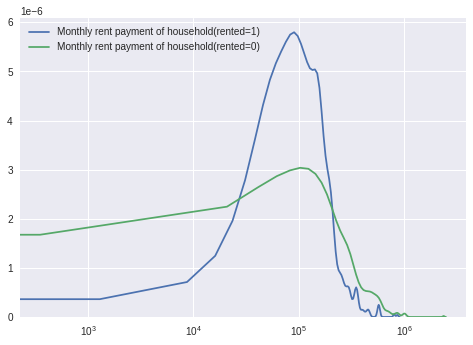

In [29]:
sns.kdeplot(df_train.loc[df_train['tipovivi3'] ==1,'v2a1'], label='Monthly rent payment of household(rented=1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] ==0,'v2a1'], label='Monthly rent payment of household(rented=0)')
plt.xscale('log')
plt.show()

In [30]:
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [31]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,9557,100.0
Target,0,0.0
sanitario3,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0
coopele,0,0.0
noelec,0,0.0
planpri,0,0.0
public,0,0.0
abastaguano,0,0.0


In [32]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,23856,100.0
abastaguano,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0
coopele,0,0.0
noelec,0,0.0
planpri,0,0.0
public,0,0.0
abastaguafuera,0,0.0
sanitario5,0,0.0


이제 결측치(NaN values)는 없다.

# 2. Feature Engineering
## 2.1 Object features

In [33]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

### dependency


In [34]:
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

### edjefe
- 교육연수가 있다는 가정하에 남자 가장의 교육 연수를 뜻한다. 
- yes ->1 , no ->0으로 대체한다.

In [35]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
    
df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)
df_test['edjefe'] = df_test['edjefe'].apply(replace_edjefe).astype(float)

### edjefa
- 교육연수가 있다는 가정하에 여자 가장의 교육연수를 의미한다. 
- yes->1, no->0으로 대체한다.

In [36]:
def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)
df_test['edjefa'] = df_test['edjefa'].apply(replace_edjefa).astype(float)

In [37]:
# 여자나 남자 중에 가장의 교육연수가 가장 큰 값으로 변수를 생성한다.
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

### roof and electricity

In [38]:
# 초기화
df_train['roof_waste_material'] = np.nan
df_test['roof_waste_material'] = np.nan
df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0) :
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0) :
        return 1
    else:
        return 0
    
df_train['roof_waste_material'] = df_train.apply(lambda x : fill_roof_exception(x), axis=1)
df_test['roof_waste_material'] = df_test.apply(lambda x : fill_roof_exception(x), axis=1)
df_train['electricity_other'] = df_train.apply(lambda x : fill_no_electricity(x), axis=1)
df_test['electricity_other'] = df_test.apply(lambda x : fill_no_electricity(x), axis=1)

## 카테고리 변수 추출

In [39]:
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2]
len(binary_cat_features) # 이진 카테고리 변수 추출 

103

## 2.3 연속형 변수를 사용하여 새로운 변수 생성

### 연속형 변수 컬럼 추출

In [40]:
continuous_features = [col for col in df_train.columns if col not in binary_cat_features] # unique한 value가 2개일 경우(이진 값)
continuous_features = [col for col in continuous_features if col not in features_object]
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target','idhogar']]

In [41]:
print('Threr are {} continuous features'.format(len(continuous_features)))
for col in continuous_features:
    print('{}: {}'.format(col, description_ko.loc[description_ko['varname'] == col, 'description'].values))

Threr are 37 continuous features
v2a1: ['월세납부']
rooms: ['집 안의 모든 방의 수']
v18q1: ['가구 소유의 태블릿 수']
r4h1: ['12세 미만의 남성']
r4h2: ['남성 12세 이상']
r4h3: ['가구원수합계']
r4m1: ['12세 이하 여성']
r4m2: ['12세 이상 여성']
r4m3: ['가구원 총여성']
r4t1: ['12세 이하인 사람']
r4t2: ['12세 이상']
r4t3: ['가구원 합계']
tamhog: ['가구원수']
tamviv: ['가구원수']
escolari: ['다년간의 교육']
rez_esc: ['학창시절 몇년 뒤']
hhsize: ['가구 크기']
elimbasu5: ['=1 주로 강, 하천 또는 바다에 투척하여 쓰레기를 처리하는 경우']
hogar_nin: ['0~19세인 가구원 수 ']
hogar_adul: ['어른인 가구원수']
hogar_mayor: ['65세 이상인 가구원수 ']
hogar_total: ['가구원 총 인원수']
meaneduc: ['평균 성인 교육년(18+)']
bedrooms: ['침실 수']
overcrowding: ['# 객실당 인원수']
qmobilephone: ['휴대전화 번호']
age: ['연령']
SQBescolari: ['에스코라리 제곱']
SQBage: ['나이 제곱']
SQBhogar_total: ['hogar_total 제곱']
SQBedjefe: ['에드제프 제곱']
SQBhogar_nin: ['hogar_nin 제곱']
SQBovercrowding: ['과밀 제곱']
SQBdependency: ['종속성 제곱']
SQBmeaned: ['평균 제곱']
agesq: ['나이 제곱']
edjef: []


- hhsize : household size
- tamhog : size of the household

두변수의 의미가 같으므로, tamhog는 삭제한다.

In [42]:
df_train.drop('tamhog', axis=1, inplace=True)
df_test.drop('tamhog', axis=1, inplace=True)

### 새로운 변수 생성

- Squared features
    - 많은 squared features 가 있다. 사실은 lightgbm과 같은 트리 모델에서는 그들이 필요 없다. 하지만 커널에서는 우리는 classfier로써 임배딩되어 있는 features 필터와 set entity로써는 lightgbm으로 사용할 수 있다. 그러니 지금은 그냥 두자.
    
- Family features
    - hogar_nin, hogar_adul, hogar_mayor, hogar_total, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tmbhog, tamvid, rez_esc, escolari
    - Family size features(추출 및 비율구하기)

In [43]:
df_train['adult']= df_train['hogar_adul'] - df_train['hogar_mayor']# 65이하 성인 명수
df_train['dependency_count'] = df_train['hogar_nin'] + df_train['hogar_mayor']# 65이상 노인과 0~19살 어린이,청소년
df_train['dependency'] = df_train['dependency_count'] / df_train['adult']# 의존률 노약자/성인
df_train['child_percent'] = df_train['hogar_nin'] / df_train['hogar_total']# 어린이 비율
df_train['elder_percent'] = df_train['hogar_mayor'] / df_train['hogar_total']# 노인 비율
df_train['adult_percent'] = df_train['hogar_adul'] / df_train['hogar_total'] # 성인 비율 
df_train['males_younger_12_years_percent'] = df_train['r4h1'] / df_train['hogar_total'] # 12세 이하 남자 비율 
df_train['males_older_12_years_percent'] = df_train['r4h2'] / df_train['hogar_total'] # 12세 이상 남자 비율 
df_train['males_percent'] = df_train['r4h3'] / df_train['hogar_total'] # 총 가구원수의 남자 비율 
df_train['females_younger_12_years_percent'] = df_train['r4m1'] / df_train['hogar_total'] # 12세 이하 여자 비율 
df_train['females_older_12_years_percent'] = df_train['r4m2'] / df_train['hogar_total'] # 12세 이상 여자 비율 
df_train['females_percent'] = df_train['r4m3'] / df_train['hogar_total'] # 총 가구원수의 여자 비율 
df_train['persons_younger_12_years_percent'] = df_train['r4t1'] / df_train['hogar_total'] # 12세 이하 가구원수 비율 
df_train['persons_older_12_years_percent'] = df_train['r4t2'] / df_train['hogar_total'] # 12세 이상 가구원수 비율 
df_train['persons_percent'] = df_train['r4t3'] / df_train['hogar_total'] # 총 성인의 가구원수 비율 

In [44]:
# 남자, 여자 , 총인원의 가구원수의 비율 
df_test['adult']= df_test['hogar_adul'] - df_test['hogar_mayor'] # 65이하 성인 명수
df_test['dependency_count'] = df_test['hogar_nin'] + df_test['hogar_mayor'] # 65이상 노인과 0~19살 어린이,청소년
df_test['dependency'] = df_test['dependency_count'] / df_test['adult'] # 의존률 노약자/성인
df_test['child_percent'] = df_test['hogar_nin'] / df_test['hogar_total'] # 어린이 비율
df_test['elder_percent'] = df_test['hogar_mayor'] / df_test['hogar_total'] # 노인 비율
df_test['adult_percent'] = df_test['hogar_adul'] / df_test['hogar_total'] # 성인 비율 
df_test['males_younger_12_years_percent'] = df_test['r4h1'] / df_test['hogar_total'] # 12세 이하 남자 비율 
df_test['males_older_12_years_percent'] = df_test['r4h2'] / df_test['hogar_total'] # 12세 이상 남자 비율 
df_test['males_percent'] = df_test['r4h3'] / df_test['hogar_total']# 총 가구원수의 남자 비율 
df_test['females_younger_12_years_percent'] = df_test['r4m1'] / df_test['hogar_total']# 12세 이하 여자 비율 
df_test['females_older_12_years_percent'] = df_test['r4m2'] / df_test['hogar_total']# 12세 이상 여자 비율 
df_test['females_percent'] = df_test['r4m3'] / df_test['hogar_total']# 총 가구원수의 여자 비율 
df_test['persons_younger_12_years_percent'] = df_test['r4t1'] / df_test['hogar_total'] # 12세 이하 가구원수 비율 
df_test['persons_older_12_years_percent'] = df_test['r4t2'] / df_test['hogar_total']# 12세 이상 가구원수 비율
df_test['persons_percent'] = df_test['r4t3'] / df_test['hogar_total'] # 총 성인의 가구원수 비율 

In [45]:
# 남자, 여자 , 총인원의 가구원수의 비율 
df_train['males_younger_12_years_in_householde_size'] = df_train['r4h1'] / df_train['hhsize']
df_train['males_older_12_years_in_householde_size'] = df_train['r4h2'] / df_train['hhsize']
df_train['males_in_householde_size'] = df_train['r4h3'] / df_train['hhsize']
df_train['females_younger_12_years_in_householde_size'] = df_train['r4m1'] / df_train['hhsize']
df_train['females_older_12_years_in_householde_size'] = df_train['r4m2'] / df_train['hhsize']
df_train['females_in_householde_size'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_in_householde_size'] = df_train['r4t1'] / df_train['hhsize']
df_train['persons_older_12_years_in_householde_size'] = df_train['r4t2'] / df_train['hhsize']
df_train['persons_in_householde_size'] = df_train['r4t3'] / df_train['hhsize']

In [46]:
# 남자, 여자 , 총인원의 가구원수의 비율 
df_test['males_younger_12_years_in_householde_size'] = df_test['r4h1'] / df_test['hhsize']
df_test['males_older_12_years_in_householde_size'] = df_test['r4h2'] / df_test['hhsize']
df_test['males_in_householde_size'] = df_test['r4h3'] / df_test['hhsize']
df_test['females_younger_12_years_in_householde_size'] = df_test['r4m1'] / df_test['hhsize']
df_test['females_older_12_years_in_householde_size'] = df_test['r4m2'] / df_test['hhsize']
df_test['females_in_householde_size'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_in_householde_size'] = df_test['r4t1'] / df_test['hhsize']
df_test['persons_older_12_years_in_householde_size'] = df_test['r4t2'] / df_test['hhsize']
df_test['persons_in_householde_size'] = df_test['r4t3'] / df_test['hhsize']

In [47]:
 # 침실 평균 최대 수용인원 
df_train['overcrowding_room_and_bedroom'] = (df_train['hacdor'] + df_train['hacapo'])/2
df_test['overcrowding_room_and_bedroom'] = (df_test['hacdor'] + df_test['hacapo'])/2

In [48]:
# 나이대별 교육 연수
df_train['escolari_age'] = df_train['escolari'] / df_train['age']
df_test['escolari_age'] = df_test['escolari'] / df_test['age']

df_train['age_12_19'] = df_train['hogar_nin'] - df_train['r4t1']
df_test['age_12_19'] = df_test['hogar_nin'] - df_test['r4t1']



In [49]:
# 실제 가구원수의 생활 방식 비율 
df_train['phones-per-capita'] = df_train['qmobilephone'] / df_train['tamviv']
df_train['tablets-per-capita'] = df_train['v18q1'] / df_train['tamviv']
df_train['rooms-per-capita'] = df_train['rooms'] / df_train['tamviv']
df_train['rent-per-capita'] = df_train['v2a1'] / df_train['tamviv']

df_test['phones-per-capita'] = df_test['qmobilephone'] / df_test['tamviv']
df_test['tablets-per-capita'] = df_test['v18q1'] / df_test['tamviv']
df_test['rooms-per-capita'] = df_test['rooms'] / df_test['tamviv']
df_test['rent-per-capita'] = df_test['v2a1'] / df_test['tamviv']

- 우리는 "Total persons in the household"와 "# of total individuals in the household"가 같지 않음을 확인할 수 있다.
- 조금 이상하긴 하지만 지금은 그냥 둔다

In [50]:
(df_train['hogar_total'] == df_train['r4t3']).sum()

9509

### 가족 변수의 대출 비율
Rent per family features

In [51]:
family_size_features= ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v2a1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v2a1'] / df_train[col]
    df_test[new_col_name] = df_test['v2a1'] / df_test[col]

- Ratio 변수는 값이 무한으로 갈수 있다. 그런 값들은 0으로 처리한다.

In [52]:
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

### 가족 변수의 방 비율 
Room per family features

In [53]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rooms'] / df_train[col]
    df_test[new_col_name] = df_test['rooms'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

### 가족 변수의 침대 비율 
BedRoom per family features

In [54]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('bedrooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['bedrooms'] / df_train[col]
    df_test[new_col_name] = df_test['bedrooms'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [55]:
# feature 갯수 확인
print(df_train.shape, df_test.shape)

(9557, 220) (23856, 219)


### 가족 변수의 태블릿 보유 비율
Tabulet per family features

In [56]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v18q1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v18q1'] / df_train[col]
    df_test[new_col_name] = df_test['v18q1'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

### 가족 변수의 핸드폰 보유 비율
phone per family features

In [57]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('qmobilephone', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['qmobilephone'] / df_train[col]
    df_test[new_col_name] = df_test['qmobilephone'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

### 가족 변수의 학창 시절의 몇년뒤 비율
rez_esc(Years behind in school:학창 시절의 몇년 뒤) per family features

In [58]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rez_esc', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rez_esc'] / df_train[col]
    df_test[new_col_name] = df_test['rez_esc'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [59]:
df_train['rez_esc_age'] = df_train['rez_esc'] / df_train['age']
df_train['rez_esc_escolari'] = df_train['rez_esc'] / df_train['escolari']

df_test['rez_esc_age'] = df_test['rez_esc'] / df_test['age']
df_test['rez_esc_escolari'] = df_test['rez_esc'] / df_test['escolari']

### Rich features
- 필자는 phone이나 tabulet 많으면 부자라고 판단하고, 부자 관련 변수를 생성함

In [60]:
df_train['tabulet_x_qmobilephone'] = df_train['v18q1'] * df_train['qmobilephone']
df_test['tabulet_x_qmobilephone'] = df_test['v18q1'] * df_test['qmobilephone']

- wall(벽), roof(지붕), floor(바닥)도 중요한 키요소이다.
- 이제 변수들의 값을 곱해보자. 왜냐하면 그 변수들은 이진 카테고리 변수이기 때문이다. 그래서 각각의 변수들의 곱으로 새로운 카테고리 변수를 생성한다.
    - "epared1"," =1 if walls are bad"
    - "epared2"," =1 if walls are regular"
    - "epared3"," =1 if walls are good"
    - "etecho1"," =1 if roof are bad"
    - "etecho2"," =1 if roof are regular"
    - "etecho3"," =1 if roof are good"
    - "eviv1"," =1 if floor are bad"
    - "eviv2"," =1 if floor are regular"
    - "eviv3"," =1 if floor are good"

In [61]:
# wall and roof
for col1 in ['epared1','epared2','epared3']:
    for col2 in ['etecho1','etecho2','etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
# wall and floor
for col1 in ['epared1','epared2','epared3']:
    for col2 in ['eviv1','eviv2','eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
        
# roof and floor
for col1 in ['etecho1','etecho2','etecho3']:
    for col2 in ['eviv1','eviv2','eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [62]:
# 3개 변수 합치기
for col1 in ['epared1','epared2','epared3']:
    for col2 in ['etecho1','etecho2','etecho3']:
        for col3 in ['eviv1','eviv2','eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
#             df_test[new_col_name] = df_test[col1] * df_test[col2] * df_test[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [63]:
print(df_train.shape, df_test.shape)

(9557, 322) (23856, 321)


- electricity와 energy 변수는 energy 변수로 합친다.

In [64]:
for col1 in ['public', 'planpri', 'noelec', 'coopele']:
    for col2 in ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

- 화장실과 쓰레기 처리변수는 other_infra 변수로 처리한다.

In [65]:
for col1 in ['sanitario1', 'sanitario2', 'sanitario3','sanitario5','sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

- 화장실과 물 공급은 water 변수로 처리한다.

In [66]:
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3','sanitario5','sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]      

In [67]:
print(df_train.shape, df_test.shape)

(9557, 383) (23856, 382)


- 교육과 지역을 education_zone 변수로 처리한다.

In [68]:
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6',
                'instlevel7','instlevel8','instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]   

- 종교와 교육을 합친다.

In [69]:
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4','lugar5', 'lugar6']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6',
                'instlevel7','instlevel8','instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]   

In [70]:
print(df_train.shape, df_test.shape)

(9557, 455) (23856, 454)


- television / mobilephone / computer / tabulet / refrigerator 모두 곱한 값을 electronics 변수로 처리한다.
- television / mobilephone / computer / tabulet / refrigerator 모두 더한 값을 no_appliances 변수로 처리한다.

In [71]:
df_train['electronics'] = df_train['computer'] * df_train['mobilephone'] * df_train['television'] * df_train['v18q'] * df_train['refrig']
df_train['no_appliances'] = df_train['refrig'] + df_train['computer'] + df_train['television'] + df_train['refrig']

df_test['electronics'] = df_test['computer'] * df_test['mobilephone'] * df_test['television'] * df_test['v18q'] * df_test['refrig']
df_test['no_appliances'] = df_test['refrig'] + df_test['computer'] + df_test['television'] + df_test['refrig']

- roof, floor, wall의 재료 변수를 합친다.

In [72]:
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes','paredmad','paredzinc','paredfibras','paredother']:
    for col2 in ['pisomoscer','pisocemento','pisoother','pisonatur','pisonotiene','pisomadera']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]   
        
for col1 in ['pisomoscer','pisocemento','pisoother','pisonatur','pisonotiene','pisomadera']:
    for col2 in ['techozinc','techoentrepiso','techocane','techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]   
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes','paredmad','paredzinc','paredfibras','paredother']:
    for col2 in ['techozinc','techoentrepiso','techocane','techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]   
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes','paredmad','paredzinc','paredfibras','paredother']:
    for col2 in ['pisomoscer','pisocemento','pisoother','pisonatur','pisonotiene','pisomadera']:
        for col3 in ['techozinc','techoentrepiso','techocane','techootro']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_test[col3]  

In [73]:
print(df_train.shape, df_test.shape)

(9557, 753) (23856, 752)


오직 한개의값만 있는 변수는 지우기

In [74]:
col_with_only_one_value=[]
for col in df_train.columns:
    if col == 'Target':
        continue
    if df_train[col].value_counts().shape[0] == 1 or df_test[col].value_counts().shape[0] == 1 :
        print(col)
        col_with_only_one_value.append(col)

elimbasu5
new_planpri_x_energcocinar1
new_planpri_x_energcocinar2
new_planpri_x_energcocinar3
new_planpri_x_energcocinar4
new_noelec_x_energcocinar2
new_sanitario1_x_elimbasu4
new_sanitario1_x_elimbasu5
new_sanitario1_x_elimbasu6
new_sanitario2_x_elimbasu4
new_sanitario2_x_elimbasu5
new_sanitario2_x_elimbasu6
new_sanitario3_x_elimbasu5
new_sanitario5_x_elimbasu4
new_sanitario5_x_elimbasu5
new_sanitario5_x_elimbasu6
new_sanitario6_x_elimbasu2
new_sanitario6_x_elimbasu4
new_sanitario6_x_elimbasu5
new_sanitario6_x_elimbasu6
new_abastaguafuera_x_sanitario6
new_abastaguano_x_sanitario2
new_abastaguano_x_sanitario6
new_paredblolad_x_pisonatur
new_paredblolad_x_pisonotiene
new_paredzocalo_x_pisoother
new_paredzocalo_x_pisonatur
new_paredpreb_x_pisonatur
new_pareddes_x_pisoother
new_pareddes_x_pisonatur
new_paredmad_x_pisoother
new_paredmad_x_pisonatur
new_paredzinc_x_pisoother
new_paredzinc_x_pisonatur
new_paredfibras_x_pisoother
new_paredfibras_x_pisonatur
new_paredfibras_x_pisonotiene
new_p

In [75]:
df_train.drop(col_with_only_one_value, axis=1, inplace=True)
df_test.drop(col_with_only_one_value, axis=1, inplace=True)

train과 test 데이터의 변수가 개수가 같은지 체크한다.

In [76]:
col_train = np.array(sorted([col for col in df_train.columns if col != 'Target']))
col_test = np.array(sorted(df_test.columns))

In [77]:
(col_train == col_test).sum() == len(col_train)

True

## 2.4 집합 변수
aggregation features

In [78]:
def max_min(x):
    return x.max() - x.min()

In [79]:
agg_train = pd.DataFrame()
agg_test = pd.DataFrame()

for item in tqdm(family_size_features):
    for i, function in enumerate(['mean','std','min','max','sum','count', max_min]):
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new_' + 'max_min'
        else:
            new_col = item + '_new_' + function
            
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
        
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 15/15 [00:09<00:00,  1.63it/s]

new aggregate train set has 2988 rows, and 105 features
new aggregate test set has 7352 rows, and 105 features


In [80]:
# 집합 변수 리스트 선언
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
              'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
              'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 
             'parentesco10', 'parentesco11', 'parentesco12',
              'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
             'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
             'area1', 'area2', 'v18q', 'edjef']

In [81]:
for item in tqdm(aggr_list):
    for function in ['count','sum']:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        new_col = item + '_new1_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))
    

100%|██████████| 47/47 [00:01<00:00, 40.94it/s]

new aggregate train set has 2988 rows, and 199 features
new aggregate test set has 7352 rows, and 199 features


In [82]:
aggr_list = ['escolari', 'age', 'escolari_age', 'dependency', 'bedrooms', 'overcrowding', 'rooms', 'qmobilephone', 'v18q1']

for item in tqdm(aggr_list):
    for function in ['mean','std','min','max','sum','count', max_min]:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new2_' + 'max_min'
        else:
            new_col = item + '_new2_' + function            
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
        
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 9/9 [00:05<00:00,  1.56it/s]

new aggregate train set has 2988 rows, and 208 features
new aggregate test set has 7352 rows, and 208 features


In [83]:
agg_test = agg_test.reset_index()
agg_train = agg_train.reset_index()

train_agg = pd.merge(df_train, agg_train, on='idhogar')
test = pd.merge(df_test, agg_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 733) test shape: (23856, 732)


In [84]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']

In [85]:
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5','lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar,'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar,col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar,'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar,col) for col in group_test][2:]
    
    train_agg = pd.merge(train_agg, group_train, on =[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on = [lugar, 'idhogar'])

print('train shape:', train_agg.shape, 'test shape:', test.shape)


train shape: (9557, 1015) test shape: (23856, 1014)


In [86]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']

for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5','lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar,'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar,col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar,'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar,col) for col in group_test][2:]
    
    train_agg = pd.merge(train_agg, group_train, on =[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on = [lugar, 'idhogar'])

print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1297) test shape: (23856, 1296)


In [87]:
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

for function in tqdm(['mean','std','min','max','sum','count', max_min]):
    for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5','lugar6']:
        group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar,'idhogar']).agg(function).reset_index()
        group_train.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_train][2:]        

        group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar,'idhogar']).agg(function).reset_index()
        group_test.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_test][2:]        

        train_agg = pd.merge(train_agg, group_train, on =[lugar, 'idhogar'])
        test = pd.merge(test, group_test, on = [lugar, 'idhogar'])

print('train shape:', train_agg.shape, 'test shape:', test.shape)

100%|██████████| 7/7 [02:33<00:00, 21.93s/it]

train shape: (9557, 3271) test shape: (23856, 3270)


- 데이터 설명에 따르면 점수 매기는 것은 household만 사용된다.
- 모든 가구원은 test + sample submission 에는 포함되지만, 가구원수만 점수에 매겨진다. 

In [88]:
train = train_agg.query('parentesco1==1')

In [89]:
train['dependency'].replace(np.inf, 0, inplace=True)
test['dependency'].replace(np.inf, 0, inplace=True)

In [90]:
submission = test[['Id']]

# 필요없는 변수는 차원을 감소 시키기위해 삭제한다.
train.drop(columns=['idhogar','Id', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 
                    'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True )

test.drop(columns=['idhogar','Id', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 
                    'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True )

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)

In [91]:
print('final_data size', train.shape, test.shape)

final_data size (2973, 3259) (23856, 3258)


In [92]:
print(f'The most 20 positive feature: \n {correlation.head(20)}')


The most 20 positive feature: 
 Target                            1.000000
new5_lugar3_idhogar_edjef_max     0.334254
new5_lugar4_idhogar_edjef_max     0.334254
new5_lugar6_idhogar_edjef_max     0.334254
new5_lugar2_idhogar_edjef_max     0.334254
new5_lugar1_idhogar_edjef_max     0.334254
new5_lugar5_idhogar_edjef_max     0.334254
new5_lugar6_idhogar_edjef_mean    0.333873
new5_lugar5_idhogar_edjef_mean    0.333873
new5_lugar2_idhogar_edjef_mean    0.333873
new5_lugar4_idhogar_edjef_mean    0.333873
new5_lugar1_idhogar_edjef_mean    0.333873
new5_lugar3_idhogar_edjef_mean    0.333873
edjef                             0.333791
new5_lugar5_idhogar_edjef_min     0.333791
new5_lugar3_idhogar_edjef_min     0.333791
new5_lugar1_idhogar_edjef_min     0.333791
new5_lugar4_idhogar_edjef_min     0.333791
new5_lugar2_idhogar_edjef_min     0.333791
new5_lugar6_idhogar_edjef_min     0.333791
Name: Target, dtype: float64


In [93]:
print(f'The most 20 negaitive feature: \n {correlation.tail(20)}')

The most 20 negaitive feature: 
 new5_lugar5_idhogar_television_<function max_min at 0x7f61ca6fc0d0>    NaN
new5_lugar5_idhogar_mobilephone_<function max_min at 0x7f61ca6fc0d0>   NaN
new5_lugar5_idhogar_area1_<function max_min at 0x7f61ca6fc0d0>         NaN
new5_lugar5_idhogar_area2_<function max_min at 0x7f61ca6fc0d0>         NaN
new5_lugar5_idhogar_v18q_<function max_min at 0x7f61ca6fc0d0>          NaN
new5_lugar6_idhogar_epared1_<function max_min at 0x7f61ca6fc0d0>       NaN
new5_lugar6_idhogar_epared2_<function max_min at 0x7f61ca6fc0d0>       NaN
new5_lugar6_idhogar_epared3_<function max_min at 0x7f61ca6fc0d0>       NaN
new5_lugar6_idhogar_etecho1_<function max_min at 0x7f61ca6fc0d0>       NaN
new5_lugar6_idhogar_etecho2_<function max_min at 0x7f61ca6fc0d0>       NaN
new5_lugar6_idhogar_etecho3_<function max_min at 0x7f61ca6fc0d0>       NaN
new5_lugar6_idhogar_eviv1_<function max_min at 0x7f61ca6fc0d0>         NaN
new5_lugar6_idhogar_eviv2_<function max_min at 0x7f61ca6fc0d0>     

# 3. Feature Selection Using Shap


In [94]:
# 중복되는 열이 있으므로, 중복되는 열을 삭제하고 binary category 변수를 생성한다.
# train = train.T.drop_duplicates().T
binary_cat_features = [col for col in train.columns if train[col].value_counts().shape[0] == 2]
object_features = ['edjefe', 'edjefa']

categorical_feats = binary_cat_features + object_features

In [95]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [96]:
y = train['Target']
train.drop(columns=['Target'], inplace=True)

In [97]:
def print_execution_time(start):
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('*'*20, "Execution ended in {:0>2}h {:0>2}m {:05.2f}s".format(int(hours),int(minutes),seconds), '*'*20)

In [98]:
# LGBMClassifier https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# def extract_good_features_using_shap_LGB(params, SEED):
#     clf = lgb.LGBMClassifier(objective='multiclass',
#                             random_state=1989,
#                             max_depth=params['max_depth'],#max_depth:트리의 최대 깊이
#                             learning_rate=params['learning_rate'],#learning_rate : 학습률
#                             silent=True,
#                             metric='multi_logloss',
#                             n_jobs=-1, n_estimators =10000,#n_estimators : 반복하려는 트리의 개수
#                             class_weight = 'balanced',
#                             colsample_bytree=params['colsample_bytree'],
#                             min_split_gain=params['min_split_gain'],
#                             bagging_freq=params['bagging_freq'],
#                             min_child_weight=params['min_child_weight'],#min_child_samples : 리프 노드가 되기 위한 최소한의 샘플 데이터 수
#                              num_leaves=params['num_leaves'],#num_leaves:하나의 트리가 가질수 있는 최대의 리프 개수
#                              subsample=params['subsample'],
#                              reg_alpha=params['reg_alpha'],#reg_alpha:L2regularization
#                              reg_lambda=params['reg_lambda'],#reg_lambda:L1regularization
#                              num_class=len(np.unique(y)),
#                              bagging_seed=SEED,
#                              seed=SEED                             
#                             )
#     kfold = 5
#     kf = StratifiedKFold(n_splits=kfold, shuffle=True)
#     feat_importance_df = pd.DataFrame()
    
#     for i, (train_index, test_index) in enumerate(kf.split(train, y)): # y : Target 
#         print('='*30,'{} of {} folds'.format(i+1, kfold), '='*30)
#         start = time.time()
#         X_train, X_val = train.iloc[train_index], train_iloc[test_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[testst_index]
#         clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=evaluate_macroF1_lgb,
#                categorical_feature=categorical_feats, early_stopping_rounds=500, verbose=500)
#         shap_values=shap.TreeExplainer(clf.booster_).shap_values(X_train)
#         fold_importance_df = pd.DataFrame()
#         fold_importance_df['feature'] = X_train.columns
#         fold_importance_df['shap_values'] = abs(np.array(shap_values)[:,:].mean(1).mean(0))
#         fold_importance_df['feat_imp'] = clf.feature_importances_
#         feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
#         print_execution_time(start)
        
#     feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascendig=False).reset_index()
    
#     return feat_importance_df_shap

In [99]:
def extract_good_features_using_shap_LGB(params, SEED):
    clf = lgb.LGBMClassifier(objective='multiclass',
                             random_state=1989,
                             max_depth=params['max_depth'], 
                             learning_rate=params['learning_rate'],  
                             silent=True, 
                             metric='multi_logloss',
                             n_jobs=-1, n_estimators=10000, 
                             class_weight='balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight=params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha= params['reg_alpha'],
                             reg_lambda= params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )

    kfold = 5
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    feat_importance_df  = pd.DataFrame()

    for i, (train_index, test_index) in enumerate(kf.split(train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = train.iloc[train_index], train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=evaluate_macroF1_lgb, categorical_feature=categorical_feats,
                early_stopping_rounds=500, verbose=500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df['feat_imp'] = clf.feature_importances_
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        print_execution_time(start)

    feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
#     feat_importance_df_shap['shap_cumsum'] = feat_importance_df_shap['shap_values'].cumsum() / feat_importance_df_shap['shap_values'].sum()
#     good_features = feat_importance_df_shap.loc[feat_importance_df_shap['shap_cumsum'] < 0.999].feature
    return feat_importance_df_shap

In [100]:
total_shap_df  = pd.DataFrame()
NUM_ITERATIONS = 50
for SEED in range(NUM_ITERATIONS):
    print('#'*40, '{} of {} iterations'.format(SEED+1, NUM_ITERATIONS), '#' * 40)
    params = {'max_depth': np.random.choice([5, 6, 7, 8, 10, 12, -1]),
             'learning_rate': np.random.rand() * 0.02,
              'colsample_bytree': np.random.rand() * (1 - 0.5) + 0.5,
              'subsample': np.random.rand() * (1 - 0.5) + 0.5,
              'min_split_gain': np.random.rand() * 0.2,
              'num_leaves': np.random.choice([32, 48, 64]),
              'reg_alpha': np.random.rand() * 2,
              'reg_lambda': np.random.rand() *2,
              'bagging_freq': np.random.randint(4) +1,
              'min_child_weight': np.random.randint(100) + 20
             }
    temp_shap_df = extract_good_features_using_shap_LGB(params, SEED)
    total_shap_df = pd.concat([total_shap_df, temp_shap_df])

######################################## 1 of 50 iterations ########################################
============================== 1 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 1.00485	training's macroF1: 0.557042	valid_1's multi_logloss: 1.04836	valid_1's macroF1: 0.377357
Early stopping, best iteration is:
[49]	training's multi_logloss: 1.30129	training's macroF1: 0.487104	valid_1's multi_logloss: 1.27716	valid_1's macroF1: 0.387977
******************** Execution ended in 00h 00m 20.92s ********************
============================== 2 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 1.00997	training's macroF1: 0.560006	valid_1's multi_logloss: 1.08823	valid_1's macroF1: 0.38931
[1000]	training's multi_logloss: 0.895372	training's macroF1: 0.618211	valid_1's multi_logloss: 1.07981	valid_1's macroF1: 0

In [101]:
shop_sorted_df = total_shap_df.groupby('feature').mean().sort_values('shap_values', ascending = False).reset_index()
feat_imp_sorted_df = total_shap_df.groupby('feature').mean().sort_values('feat_imp', ascending=False).reset_index()
features_top_shap = shop_sorted_df['feature'][:500] # 500개 컬럼만 추출 
features_top_feat_imp = feat_imp_sorted_df['feature'][:500] # 500개 컬럼만 추출 

top_features = pd.Series(features_top_shap.tolist() + features_top_feat_imp.tolist())
top_features = top_features.unique() # features_top_shap과 features_top_feat_imp 겹치는 것은 삭제하고 유일한 값만 둔다.

# Model Development

In [104]:
new_train = train[top_features].copy()
new_test = test[top_features].copy()

In [106]:
print('new train shape:', new_train.shape, 'new test shape:', new_test.shape)

new train shape: (2973, 532) new test shape: (23856, 532)


## LGB를 통한 예측 및 변수 중요도 생성

In [107]:
# 카테고리 변수 리스트 생성
new_categorical_feats = [col for col in top_features if col in categorical_feats]

In [110]:
# LGB : Light Gradient Boost 함수 생성 
def LGB_OOF(params, categorical_feats, N_FOLDs, SEED=1989):
    clf = lgb.LGBMClassifier(objective='multiclass',
                             random_state=1989,
                             max_depth=params['max_depth'], 
                             learning_rate=params['learning_rate'],  
                             silent=True, 
                             metric='multi_logloss',
                             n_jobs=-1, n_estimators=10000, 
                             class_weight='balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight=params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha= params['reg_alpha'],
                             reg_lambda= params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )

    kfold = 10
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    feat_importance_df  = pd.DataFrame()
    predicts_result = []

    for i, (train_index, test_index) in enumerate(kf.split(new_train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = new_train.iloc[train_index], new_train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=evaluate_macroF1_lgb,categorical_feature=new_categorical_feats,
                early_stopping_rounds=500, verbose=500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df['feat_imp'] = clf.feature_importances_
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        predicts_result.append(clf.predict(new_test))
        print_execution_time(start)
    return predicts_result, feat_importance_df

In [111]:
# 셋팅값 입력 
params = {'max_depth': 6,
         'learning_rate': 0.002,
          'colsample_bytree': 0.8,
          'subsample': 0.8,
          'min_split_gain': 0.02,
          'num_leaves': 48,
          'reg_alpha': 0.04,
          'reg_lambda': 0.073,
          'bagging_freq': 2,
          'min_child_weight': 40
         }

N_Folds = 20
SEED = 1989
predicts_result, feat_importance_df = LGB_OOF(params, new_categorical_feats, N_Folds, SEED=1989)

============================== 1 of 10 folds ==============================
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 1.16249	training's macroF1: 0.569094	valid_1's multi_logloss: 1.18146	valid_1's macroF1: 0.42358
Early stopping, best iteration is:
[164]	training's multi_logloss: 1.29343	training's macroF1: 0.537105	valid_1's multi_logloss: 1.29374	valid_1's macroF1: 0.439404
******************** Execution ended in 00h 00m 19.45s ********************
============================== 2 of 10 folds ==============================
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 1.15839	training's macroF1: 0.575707	valid_1's multi_logloss: 1.1554	valid_1's macroF1: 0.394559
Early stopping, best iteration is:
[148]	training's multi_logloss: 1.29955	training's macroF1: 0.544585	valid_1's multi_logloss: 1.28984	valid_1's macroF1: 0.399304
******************** Execution ended in 00h 00m 18.94s ***

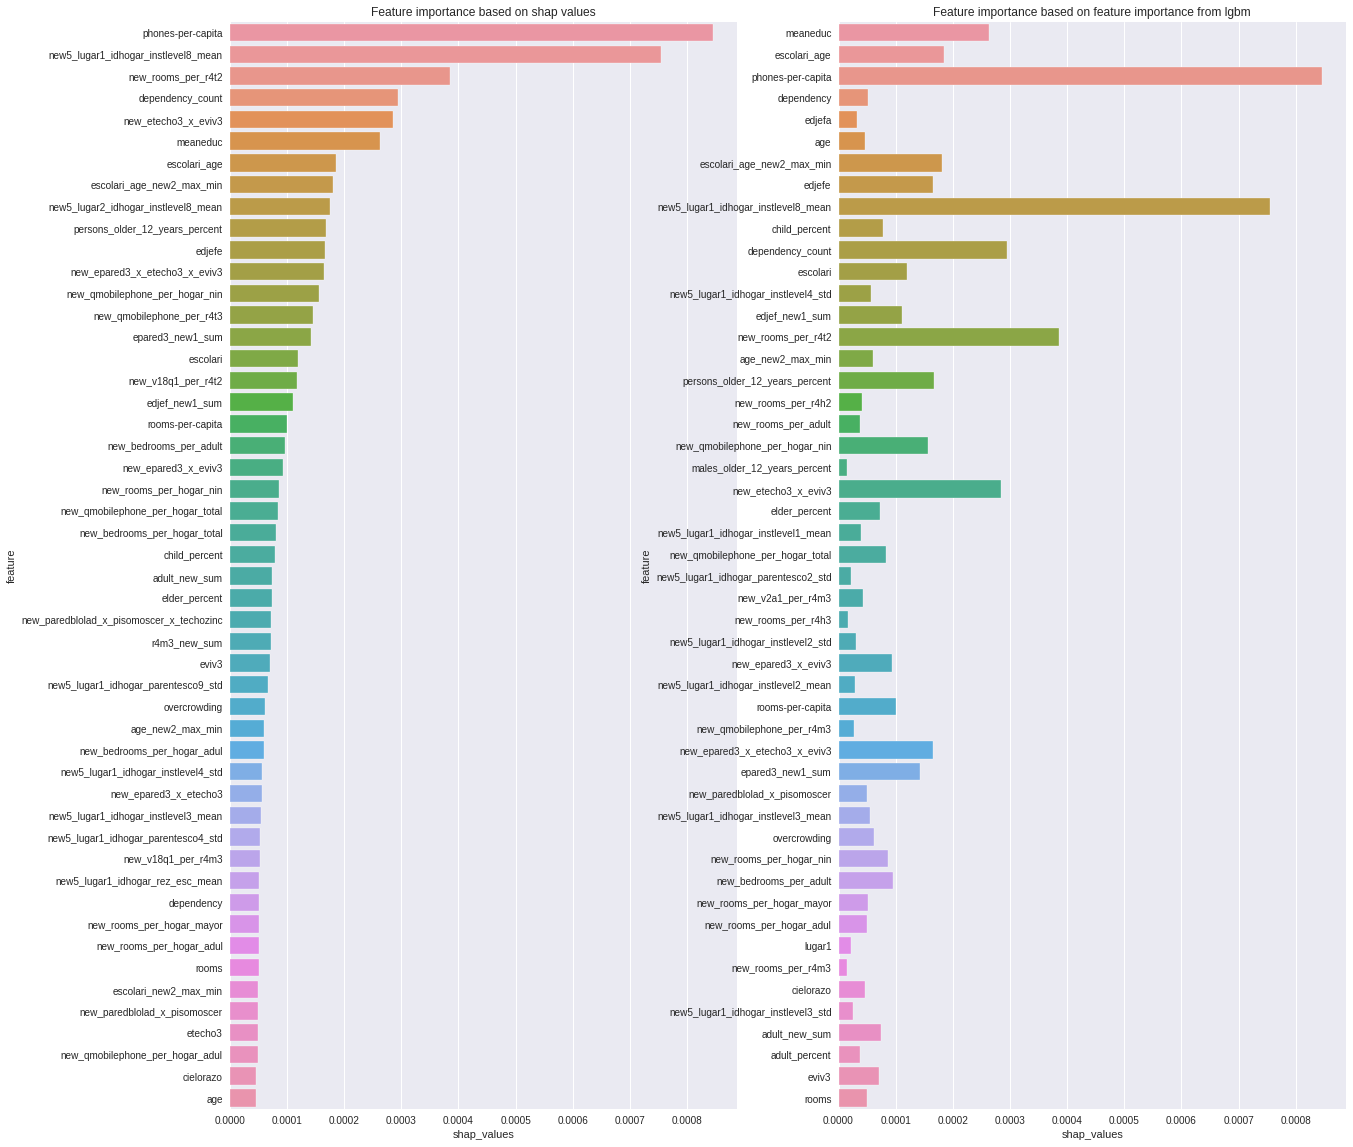

In [112]:
# 변수중요도를 그래프로 표현 
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()

num_features = 50
sns.barplot(x=feat_importance_df_shap.shap_values[:num_features], y=feat_importance_df_shap.feature[:num_features], ax=ax[0])
ax[0].set_title('Feature importance based on shap values')

feat_importance_df = feat_importance_df.groupby('feature').mean().sort_values('feat_imp', ascending=False).reset_index()

num_features = 50
sns.barplot(x=feat_importance_df.shap_values[:num_features], y=feat_importance_df.feature[:num_features], ax=ax[1])
ax[1].set_title('Feature importance based on feature importance from lgbm')
plt.show()

In [113]:
# 예측 결과 cvs 파일로 생성
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('submission_with_new_feature_set.csv', index=False)

## 랜덤하게 찾기 (Randomized Search)

In [114]:
optimized_param = None
lowest_cv = 1000
total_iteration = 100
for i in range(total_iteration):
    print('-'*20, 'For {} of {} iterations'.format(i+1, total_iteration), '-'*20)
    learning_rate = np.random.rand() * 0.02
    n_folds = 3

    num_class = len(np.unique(y))
    
    # parameter value들을 일정 범위에 맞게 random하게 설정
    params = {}
    params['application'] = 'multiclass'
    params['metric'] = 'multi_logloss'
    params['num_class'] = num_class
    params['class_weight'] = 'balanced'
    params['num_leaves'] = np.random.randint(24, 48)
    params['max_depth'] = np.random.randint(5, 8)
    params['min_child_weight'] = np.random.randint(5, 50)
    params['min_split_gain'] = np.random.rand() * 0.09
    params['colsample_bytree'] = np.random.rand() * (0.9 - 0.1) + 0.1
    params['subsample'] = np.random.rand() * (1 - 0.8) + 0.8
    params['bagging_freq'] = np.random.randint(1, 5)
    params['bagging_seed'] = np.random.randint(1, 5)
    params['reg_alpha'] = np.random.rand() * 2
    params['reg_lambda'] = np.random.rand() * 2
    params['learning_rate'] = np.random.rand() * 0.02
    params['seed']  =1989

    d_train = lgb.Dataset(data=new_train, label=y.values-1, categorical_feature=new_categorical_feats, free_raw_data=False)
    cv_results = lgb.cv(params=params, train_set=d_train, num_boost_round=10000, categorical_feature=new_categorical_feats,
                        nfold=n_folds, stratified=True, shuffle=True, early_stopping_rounds=1, verbose_eval=1000)

    min_cv_results = min(cv_results['multi_logloss-mean'])

    # 가장 작은 평균 값의 parmas을 최적화 param으로 등록
    if min_cv_results < lowest_cv:
        lowest_cv = min_cv_results
        optimized_param = params

-------------------- For 1 of 100 iterations --------------------
-------------------- For 2 of 100 iterations --------------------
-------------------- For 3 of 100 iterations --------------------
-------------------- For 4 of 100 iterations --------------------
-------------------- For 5 of 100 iterations --------------------
-------------------- For 6 of 100 iterations --------------------
-------------------- For 7 of 100 iterations --------------------
-------------------- For 8 of 100 iterations --------------------
-------------------- For 9 of 100 iterations --------------------
[1000]	cv_agg's multi_logloss: 0.850644 + 0.0107643
-------------------- For 10 of 100 iterations --------------------
-------------------- For 11 of 100 iterations --------------------
-------------------- For 12 of 100 iterations --------------------
-------------------- For 13 of 100 iterations --------------------
[1000]	cv_agg's multi_logloss: 0.844449 + 0.0113269
-------------------- For 14 of 100

In [115]:
N_Folds = 20
SEED = 1989
# 랜덤으로 추출한 변수를 LGB 함수에 적용
predicts_result, feat_importance_df = LGB_OOF(optimized_param, new_categorical_feats, N_Folds, SEED=1989)

============================== 1 of 10 folds ==============================
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 0.643909	training's macroF1: 0.767897	valid_1's multi_logloss: 1.01731	valid_1's macroF1: 0.419311
Early stopping, best iteration is:
[455]	training's multi_logloss: 0.66926	training's macroF1: 0.756981	valid_1's multi_logloss: 1.02123	valid_1's macroF1: 0.424335
******************** Execution ended in 00h 00m 31.75s ********************
============================== 2 of 10 folds ==============================
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 0.642988	training's macroF1: 0.772115	valid_1's multi_logloss: 0.973459	valid_1's macroF1: 0.441129
Early stopping, best iteration is:
[246]	training's multi_logloss: 0.836124	training's macroF1: 0.70146	valid_1's multi_logloss: 1.00646	valid_1's macroF1: 0.460188
******************** Execution ended in 00h 00m 22.09

In [ ]:
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('submission_shap_randomized_search.csv', index = False)